**input embedding**

In [70]:
import torch
import torch.nn as nn
import math
class InputEmbedding(nn.Module):
    def __init__(self, d_model, vocab_size):
        """
        :param d_model: 词嵌入的维度，最后embedding的维度
        :param vocab_size: 词表的大小，即词表中单词的个数
        return:x(batch_size, seq_len) -> (batch_size, seq_len, d_model)
        """
        super(InputEmbedding, self).__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)
    def forword(self, x):
        return self.embedding(x) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))

**Positional encoding**
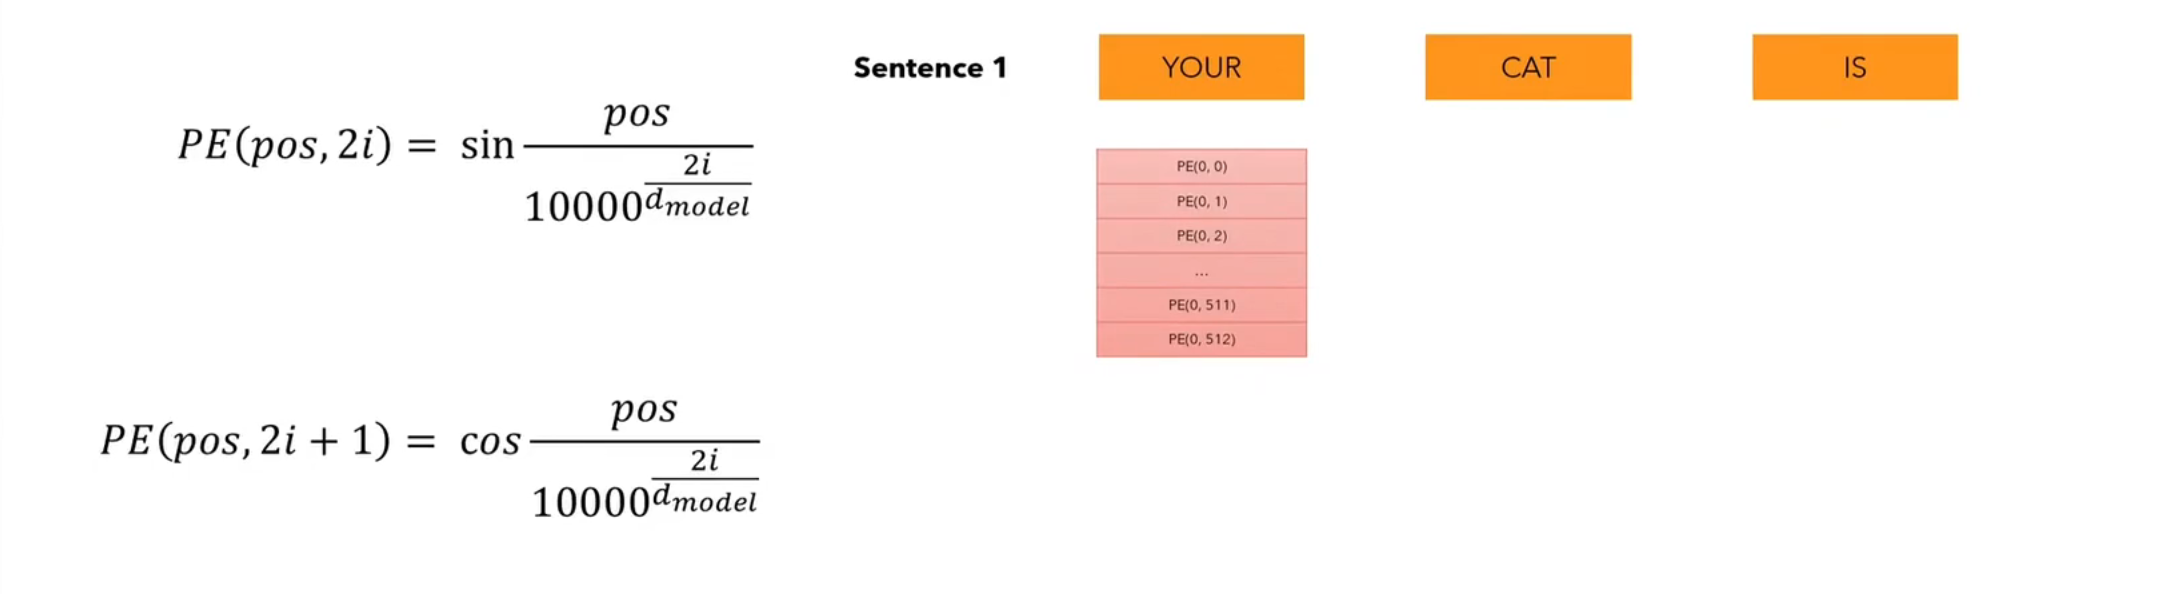

In [71]:
class PositionEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, seq_len=5000):
        """
        :param d_model: 词嵌入的维度
        :param dropout: 随机置零比率
        :param seq_len: 每个句子的最大长度
        """
        super(PositionEncoding, self).__init__()
        self.d_model=d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(p=dropout)

        pe=torch.zeros(seq_len,d_model)

        position=torch.arange(0,seq_len,dtype=torch.float).unsqueeze(1)#(seq_len,1)
        div_term=torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)/d_model))#（d_model/2） *对应元素相乘

        #position*div_term 维度为（seq_len,d_model/2）

        #对偶数维度进行正弦编码，对奇数维度进行余弦编码
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)

        pe=pe.unsqueeze(0)#(1,seq_len,d_model)
        # self.pe=pe
        self.register_buffer('pe',pe)#将pe注册为模型的buffer，对模型有帮助，但是不属于模型结构
        #buffer:模型中的一种持久状态，不需要被优化器更新

    def forward(self,x):
        #x:(batch_size,seq_len,d_model)
        x=x+(self.pe[:,:x.shape[1],:]).requires_grad_(False)
        return self.dropout(x)



**Layer Normalization**

In [72]:
class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-6):
        """
        Layer normalization layer
        
        :param eps: a value added to the denominator for numerical stability
        """
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(1))#nn.Parameter 是一个特殊的tensor，当它作为一个属性分配给一个Module时，它会被自动注册为一个参数。可被学习
        self.beta = nn.Parameter(torch.zeros(1))
    def forward(self, x):

        # x: input(batch_size, seq_len, feature_dim)
        # mean: mean value of each frame
        # std: standard deviation of each frame
        mean = x.mean(dim=-1, keepdim=True)  # (保持维度不变)，mean: (batch_size, seq_len, 1)
        std = x.std(dim=-1, keepdim=True)  # (保持维度不变)，std: (batch_size, seq_len, 1),标准差
        x=x-mean/torch.sqrt(std**2+self.eps)
        return self.gamma*x+self.beta

**Feed-Forward Network**


In [73]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
    def forward(self,x):
        #x (batch,seq_len,d_model))-->(batch,seq_len,d_ff)-->(batch,seq_len,d_model)
        x=self.linear_1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.linear_2(x)
        return x

**Multi-Head Attention**  

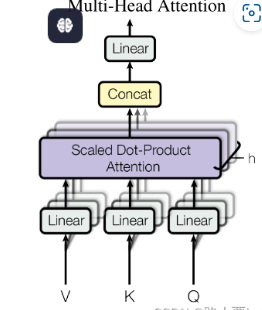

最后一个线性层用来降维

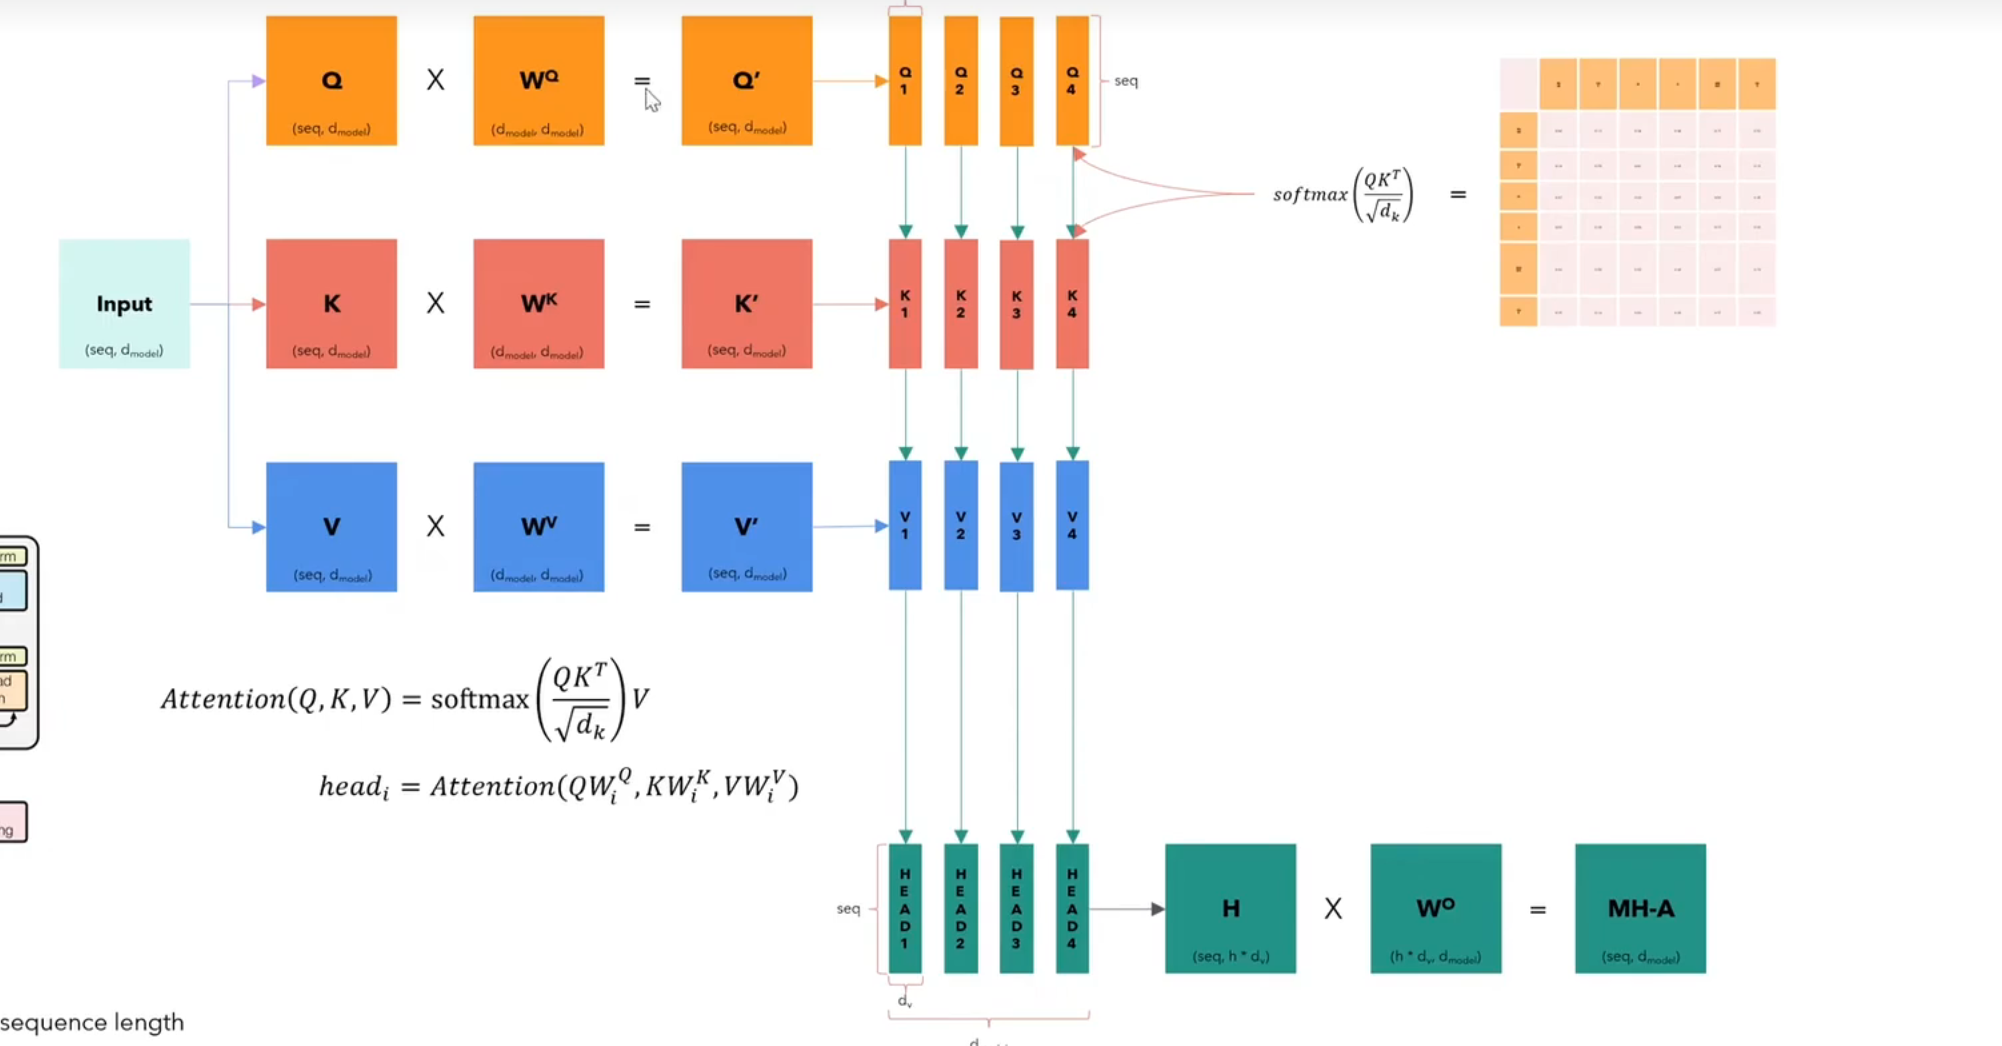

In [74]:
import torch.nn.functional as F
class MutiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads,dropout:float):
        """
        :param d_model: 输入的维度
        :param num_heads: 头的数量
        :param dropout: 丢弃率
        """
        super(MutiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        # 每个头的维度
        self.head_dim = d_model // num_heads
        # 线性层,得到q,k,v
        self.query = nn.Linear(d_model, d_model,bias=False)#wq
        self.key = nn.Linear(d_model, d_model,bias=False)#wk
        self.value = nn.Linear(d_model, d_model,bias=False)#wv
        self.fc = nn.Linear(d_model, d_model,bias=False)#wo
        self.dropout = nn.Dropout(dropout)
    def forward(self, q,k,v,mask=None):#mask在decoder上使用，用来确保预测时只关注当前位置之前的词
        query = self.query(q)#(batch_size,seq_len,d_model)-->(batch_size,seq_len,d_model)
        key = self.key(k)#(batch_size,seq_len,d_model)-->(batch_size,seq_len,d_model)
        value = self.value(v)#(batch_size,seq_len,d_model)-->(batch_size,seq_len,d_model)

        # 将q,k,v进行拆分（multi-head）
        query = query.view(query.shape(0), query.shaoe(1), self.num_heads, self.head_dim).transpose(1, 2)#(batch_size,seq_len,d_model)-->(batch_size,num_heads,seq_len,head_dim)
        key=key.view(key.shape(0), key.shape(1),self.num_heads, self.head_dim).transpose(1, 2)#(batch_size,seq_len,d_model)-->(batch_size,num_heads,seq_len,head_dim)
        value=value.view(value.shape(0), value.shape(1),self.num_heads, self.head_dim).transpose(1, 2)#(batch_size,seq_len,d_model)-->(batch_size,num_heads,seq_len,head_dim)

        # 计算注意力分数
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim)#(batch_size,num_heads,seq_len,seq_len)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)#只要mask为0的位置，分数就为-1e9
        scores = F.softmax(scores, dim=-1)#(batch_size,num_heads,seq_len,seq_len)
        if self.dropout is not None:
            scores  = self.dropout(scores)

        #存储注意力分数，以用于可视化
        self.attention_scores = scores

        attention_output = torch.matmul(scores, value)#(batch_size,num_heads,seq_len,head_dim)

        # 将多头注意力结果拼接在一起

        #contiguous() 是 PyTorch 中的一个方法，它确保返回的张量在内存中是按连续块存储的。
        # 这个方法通常在我们对张量进行了操作（如 permute()、transpose() 或 view()）之后使用，因为这些操作有时会返回一个“非连续”张量。
        attention_output = attention_output.transpose(1, 2).contiguous().view(attention_output.shape(0), attention_output.shape(1), -1)#(batch_size,seq_len,d_model)

        output=self.fc(attention_output)#(batch_size,seq_len,d_model)
        return output



        

**Residual Connection**  

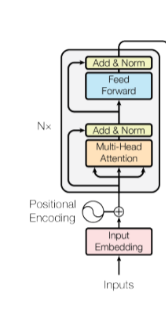

In [75]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout):
        super(ResidualConnection, self).__init__()
        
        self.dropout = nn.Dropout(dropout)
        self.norm=LayerNormalization()
    def forward(self,x,sublayer):
        #sublayer也会接受输入，返回一个输出，残差作用是原始的输入和sublayer的输出相加
        return x + self.dropout(sublayer(self.norm(x)))

**EncoderLayer!!!**  


In [76]:
import torch.nn as nn

#encoderlayer包括两个层，一个是mutihead_attention，一个是feed_forward
class EncoderLayer(nn.Module):
    """
    encoder layer包含两个子层，一个是mutihead_attention，一个是feed_forward
    return:x(batch_size,seq_len,d_model)
    """
    def __init__(self, self_attention_bloack,feed_forward_block,dropout):
        super().__init__()
        self.self_attention_bloack=self_attention_bloack
        self.feed_forward_block=feed_forward_block
        self.residual_connections=nn.ModuleList([ResidualConnection(dropout=dropout) for _ in range(2)])
    def forward(self,x,src_mask):
       
        #x(batch_size,seq_len)
       x=self.residual_connections[0](x,lambda x:self.self_attention_bloack(x,x,x,src_mask))
       x=self.residual_connections[1](x,self.feed_forward_block)
       return x

**Encoder**

In [77]:
# nn.ModuleList
class Encoder(nn.Module):
    def __init__(self,layers:nn.ModuleList):
        super().__init__()
        self.layers=layers
        self.norm=LayerNormalization()
    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)

    

**Decoder**  
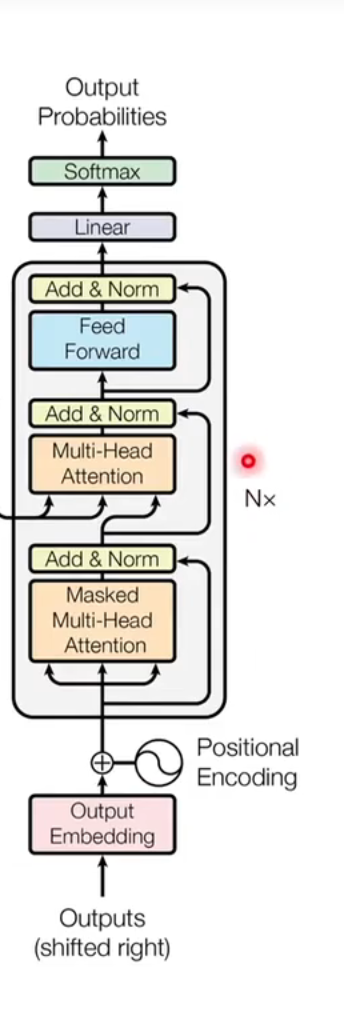


In [78]:
class DecoderLayer(nn.Module):
    def __init__(self,self_attention:MutiHeadAttention,cross_attention:MutiHeadAttention,FeedForward:FeedForward,dropout):
        super(DecoderLayer, self).__init__()
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.feed_forward = FeedForward
        self.residual=nn.ModuleList([ResidualConnection(dropout=dropout) for _ in range(3)])
    def forward(self,x,encoder_output,src_mask,tgt_mask):
        x = self.residual[0](x,lambda x:self.self_attention(x,x,x,tgt_mask))#self_attentuin
        x = self.residual[1](x,lambda x:self.cross_attention(x,encoder_output,encoder_output,src_mask))#cross_attention,decoder第二个attention，query是decoder的输入，key和value是encoder的输出
        return self.residual[2](x,self.feed_forward)

**Decoder**

In [79]:
class Decoder(nn.Module):
    def __init__(self,layers):
        super(Decoder, self).__init__()
        self.layers = layers
        
        self.norm=LayerNormalization()
    def forward(self,x,encoder_output,src_mask,tgt_mask):
        for layer in self.layers:
            x=layer(x,encoder_output,src_mask,tgt_mask)
        return self.norm(x)
        

**decoder输出后的线性层**  

**作用**：将decoder的输出映射到目标语言的词表大小，以便进行下一步的词表预测。

In [80]:
class ProjectionLayer(nn.Module):
    def __init__(self,
                 d_model,
                 vocab_size):
        super().__init__()
        self.projection = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        # (batch, seq_len, d_model) -> (batch, seq_len, vocab_size)
        return torch.log_softmax(self.projection(x), dim=-1)#log_softmax 将log和softmax结合在一起,为了防止数值溢出

**Transformer!!!**


In [81]:
class Transformer(nn.Module):
    def __init__(self, encoder:Encoder,decoder:Decoder,src_embedding:InputEmbedding,target_embedding:InputEmbedding,src_pos:PositionEncoding,target_pos:PositionEncoding,projection_layer:ProjectionLayer):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        #encoder输入
        self.src_embedding = src_embedding
        #decoder输入
        self.target_embedding = target_embedding
        #encoder位置编码
        self.src_pos = src_pos
        #decoder位置编码
        self.target_pos = target_pos
        #输出投影层，输出vocap_size个词的概率
        self.projection_layer = projection_layer
    
    #不写forward,而是分别写encode和decode，projection_layer，这样可以方便的进行训练和推理，分别保存对应的参数，也方便可视化attention
    def encode(self,src,src_mask):
        #src:输入的源语言句子
        #src_mask:源语言句子的mask
        src = self.src_embedding(src)
        src = self.src_pos(src)
        return self.encoder(src,src_mask)
    def decode(self,encoder_output:torch.Tensor,src_mask:torch.Tensor,target:torch.Tensor,target_mask:torch.Tensor):
        #encoder_output:encoder的输出
        #src_mask:源语言句子的mask
        #target:目标语言的句子
        #target_mask:目标语言句子的mask
        target = self.target_embedding(target)
        target = self.target_pos(target)
        return self.decoder(target,encoder_output,src_mask,target_mask)

    def project(self,x):
        #x:decoder的输出
        #x:decoder的输出
        return self.projection_layer(x)

    

In [82]:
#为transformer各个block构建超参数

#根据 Python 的规则，默认参数不能在非默认参数之前。
def build_transformer(src_vocab_size:int,tgt_vocab_size:int,src_seq_len:int,tgt_seq_len:int,d_model=512, num_heads=8,dropout=0.1,d_ff=2048,num_layers=6):
    #构建embedding层
    src_embedding=InputEmbedding(d_model=d_model,vocab_size=src_vocab_size)
    tgt_embedding=InputEmbedding(d_model=d_model,vocab_size=tgt_vocab_size)
    #构建位置编码
    src_pos=PositionEncoding(d_model=d_model,seq_len=src_seq_len,dropout=dropout)
    tgt_pos=PositionEncoding(d_model=d_model,seq_len=tgt_seq_len,dropout=dropout)

#错误构建，只有第一层有attention，去Q,K,V参数！！！
    # self_attention=MutiHeadAttention(d_model=d_model,num_heads=num_heads,dropout=dropout)
    # cross_attention=MutiHeadAttention(d_model=d_model,num_heads=num_heads,dropout=dropout)
    # feed_forward=FeedForward(d_model=d_model,dropout=dropout,d_ff=d_ff)
    #构建Encoder——layers
    # encoder_layers=[]
    # for _ in range(num_layers):
    #     encoder_layer=EncoderLayer(self_attention_bloack=self_attention,feed_forward_block=feed_forward,dropout=dropout)
    #     encoder_layers.append(encoder_layer)
    # #构建Decoder_layers
    # decoder_layers=[]
    # for _ in range(num_layers):
    #     decoder_layer=DecoderLayer(self_attention=self_attention,cross_attention=cross_attention,FeedForward=feed_forward,dropout=dropout)
    #     decoder_layers.append(decoder_layer)

    encoder_blocks = []
    #每一层都有attention参数，feed_forward参数
    for _ in range(num_layers):
        encoder_self_attention_block = MutiHeadAttention(d_model, num_heads=num_heads, dropout=dropout)
        feed_forward_block = FeedForward(d_model, d_ff, dropout)
        encoder_block = EncoderLayer(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(num_layers):
        decoder_self_attention_block = MutiHeadAttention(d_model, num_heads=num_heads, dropout=dropout)
        decoder_cross_attention_block = MutiHeadAttention(d_model, num_heads, dropout)
        feed_forward_block = FeedForward(d_model, d_ff, dropout)
        decoder_block = DecoderLayer(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)



    #构建Encoder
    encoder=Encoder(layers=nn.ModuleList(encoder_blocks))
    #构建Decoder
    decoder=Decoder(layers=nn.ModuleList(decoder_blocks))

    #projection_layer
    projection_layer=ProjectionLayer(d_model=d_model,vocab_size=tgt_vocab_size)

    transformer=Transformer(encoder=encoder,decoder=decoder,src_embedding=src_embedding,target_embedding=tgt_embedding,src_pos=src_pos,target_pos=tgt_pos,projection_layer=projection_layer)

    #初始化参数
    for p in transformer.parameters():
        if p.dim()>1:
            nn.init.xavier_uniform_(p)

    return transformer

    


In [ ]:
Transformer=build_transformer(src_seq_len=256,tgt_seq_len=256,src_vocab_size=512,tgt_vocab_size=512)
for name,param in Transformer.named_parameters():
    print(name,param.shape)

**训练一个nlp翻译任务**

In [84]:
import torch
import torch.nn as nn
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from pathlib import Path
from torch.utils.data import DataLoader,Dataset,random_split
from torch.utils.tensorboard import SummaryWriter
from config import  get_weights_file_path,get_config
from tqdm import tqdm
import warnings

In [85]:
#构建数据集
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Transform the text into tokens
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Add sos, eos and padding to each sentence
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # We will add <s> and </s>
        # We will only add <s>, and </s> only on the label
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        # Make sure the number of padding tokens is not negative. If it is, the sentence is too long
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        # Add <s> and </s> token
        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only <s> token
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only </s> token
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Double check the size of the tensors to make sure they are all seq_len long
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # (seq_len)
            "decoder_input": decoder_input,  # (seq_len)
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1, 1, seq_len)
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len),
            "label": label,  # (seq_len)
            "src_text": src_text,
            "tgt_text": tgt_text,
        }
    
def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

In [ ]:

def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_step, writer, num_examples=2):
    model.eval()
    count = 0

    source_texts = []
    expected = []
    predicted = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)
            
            # Print the source, target and model output
            print_msg('-'*console_width)
            print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break
    
    if writer:
        # Evaluate the character error rate
        # Compute the char error rate 
        metric = torchmetrics.CharErrorRate()
        cer = metric(predicted, expected)
        writer.add_scalar('validation cer', cer, global_step)
        writer.flush()

        # Compute the word error rate
        metric = torchmetrics.WordErrorRate()
        wer = metric(predicted, expected)
        writer.add_scalar('validation wer', wer, global_step)
        writer.flush()

        # Compute the BLEU metric
        metric = torchmetrics.BLEUScore()
        bleu = metric(predicted, expected)
        writer.add_scalar('validation BLEU', bleu, global_step)
        writer.flush()

def get_all_sentences(ds, lang):
    """
    :param ds:dataset
    :param lang:language
    :return:
    """
    for item in ds:
        yield item['translation'][lang]
def get_or_build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    if not Path.exists(tokenizer_path):
        # Most code taken from: https://huggingface.co/docs/tokenizers/quicktour
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer
def get_ds(config):
    # It only has the train split, so we divide it overselves
    ds_raw = load_dataset('optus_books', f"{config['lang_src']}-{config['lang_tgt']}", split='train')

    # Build tokenizers
    tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Keep 90% for training, 10% for validation
    train_ds_size = int(0.9 * len(ds_raw))
    val_ds_size = len(ds_raw) - train_ds_size
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Find the maximum length of each sentence in the source and target sentence
    max_len_src = 0
    max_len_tgt = 0

    for item in ds_raw:
        src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')
    

    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt

def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], config['seq_len'], d_model=config['d_model'])
    return model


def train_model(config):
    # Define the device
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    elif (device == 'mps'):
        print(f"Device name: <mps>")
    else:
        print("NOTE: If you have a GPU, consider using it for training.")
        print("      On a Windows machine with NVidia GPU, check this video: https://www.youtube.com/watch?v=GMSjDTU8Zlc")
        print("      On a Mac machine, run: pip3 install --pre torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/nightly/cpu")
    device = torch.device(device)

    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)

    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = get_weights_file_path(config=config,preload=preload)
    if model_filename:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:

            encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compare the output with the label
            label = batch['label'].to(device) # (B, seq_len)

            # Compute the loss using a simple cross entropy,(b,seq_len,vocab_size)-->(b*seq_len,vocab_size)
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        # Run validation at the end of every epoch
        # run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)


if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    train_model(config)